# In this notebook, we'll first visualize the output of each layers and visualize weights of layers.

# Later in the notebook, we'll see how the change in the properties of the input image activate the individual filters in model.

### _Step 1: Visualize the weights in each layer_
### _Step 2: Visualize the output of individual filters in a given layer based on given input_
### _Step 3: Visualize the maximization of weights for optimized input value_
### _Step 4: Visualize what the CNN means by when fed by the output. Try to generate input image from an output label._

--------------------------------------------------------------------------------------------------------------------------------

# _Step 1: Visualize the weights in each layer_


#### _Let's load pretrained VGG16 model available in Keras. Below is the architecture of the VGG16 network for our ready reference._

![title](VGG16 architecture.png)

In [1]:
from keras.applications.vgg16 import VGG16

model = VGG16()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### _Get the weights of the layer based on layer name, post process them and plot it._  

(128, 64, 3, 3)


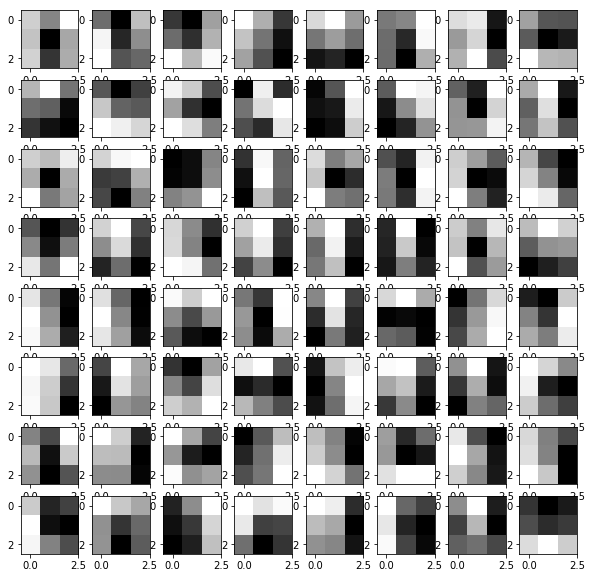

In [4]:
import numpy as np
import matplotlib.pyplot as plt

layer_variables = model.get_layer('block2_conv1').get_weights()

weights = layer_variables[0]
biases = layer_variables[1]

w = np.array(weights)
w.shape
# So there are total 128 filters in 3x3x64 size. 
# And 64 in the filter size is to directly do convolution of each 3x3 from 64 filter with 64 depths of input tensor. 
# Each of these 64 3x3 filters are there for one and only one depth of the input tensor.
# Each of these 64 filters will be differently trained and hence they will have different values at the end of training.

# Now to visualize each of the 128 filters in 3x3x64 dims we need to shift the axis

w = np.moveaxis(w, 2, 0)
w = np.moveaxis(w, 3, 0)
print(w.shape)

# the total filter in previous layers will be obtained from w.shape[1]
total_filters_in_prev_layers = 64

cols = 8
rows = 8
# rows * cols > total_filters

# current_filter = which filter's weights we want to see
current_filter = 100

fig = plt.figure(figsize=(10, 10))

for each_depth in range(w.shape[1]):
    fig.add_subplot(rows, cols, each_depth+1)
    plt.imshow(w[current_filter][each_depth], cmap='gray')

# _Step 2: Visualize the output of individual filters in a given layer based on given input_


#### _Let's load our sample image and preprocess it for the model._

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open("./input images/19047_en_1.jpg")
img2 = img.resize((224, 224))
plt.imshow(img2)

img2 = np.array(img2)
img2 = np.reshape(img2, (1, img2.shape[0], img2.shape[1], img2.shape[2]))
print(img2.shape)

# We need to feed an image having 1, 224, 224, 3 dimension

(1, 224, 224, 3)


#### _Get the intermediate layer output based on given input image._

In [6]:
from keras.models import Model

layer_name = 'block3_conv2'

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

intermediate_output = intermediate_layer_model.predict(img2)

In [7]:
print(intermediate_output.shape)

output = np.squeeze(intermediate_output)
output = np.moveaxis(output, 2, 0)

print(output.shape)

(1, 56, 56, 256)
(256, 56, 56)


#### _Plot the output of the layer in depthwise manner._

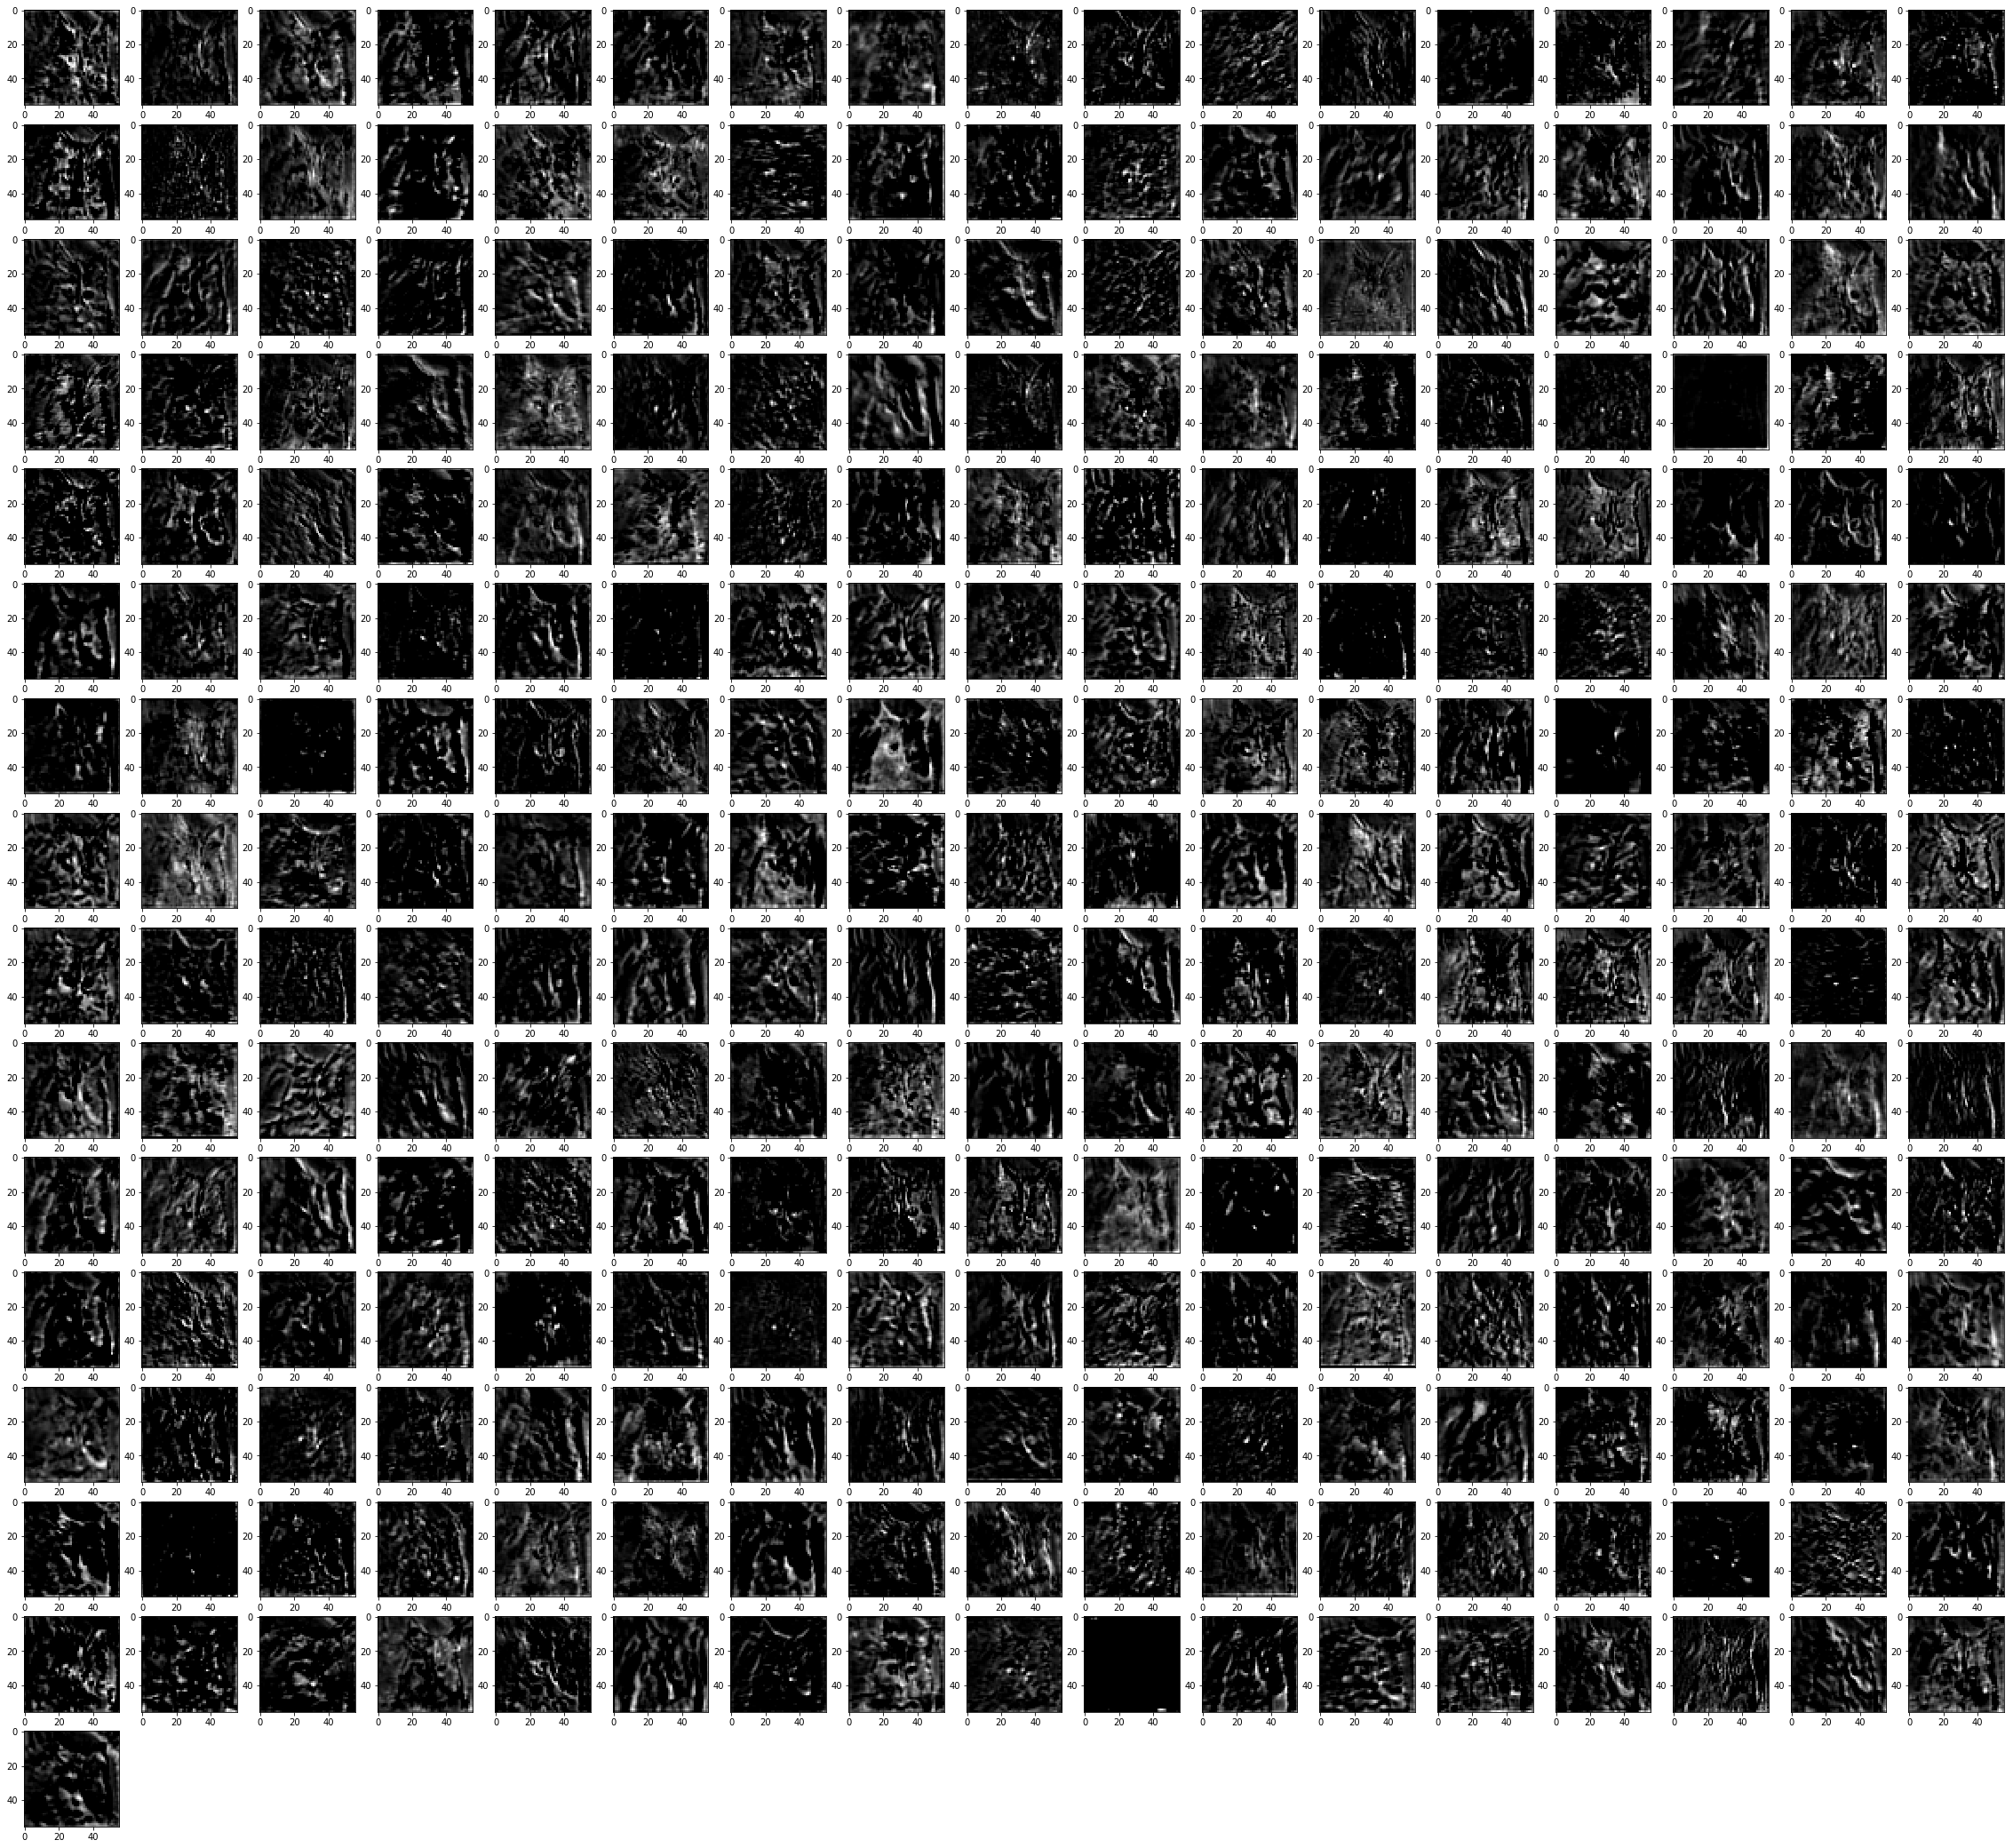

In [8]:
fig = plt.figure(figsize=(40, 40))

no_filters = 256

cols = 17
rows = 17

for i in range(output.shape[0]):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(output[i], cmap='gray')

# _Step 3: Visualize the maximization of weights for optimized input value_


#### _Let's load our VGG16 model with some changes._

In [4]:
from keras import applications

model = applications.VGG16(include_top=False, weights='imagenet')
# include_top = False will provide us VGG16 model without last 3 fully connected layers. 
# The benefit of that is - it will enable us to feed any size of image to the model.

layer_dict = dict([(layer.name, layer) for layer in model.layers])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
from keras import backend as K

input_img = model.input

layer_name = 'block4_conv1'
filter_index = 13          # consider 1st filter in layer 'block4_conv3' out of 512 total filters

layer_output = layer_dict[layer_name].output

# Loss function will be the mean of all the values in the output layer filter.
# e.g. the after convolution assume that the shape of output is 96x96 then we'll average out all the values to have a single value
loss_fxn = K.mean(layer_output[:, :, :, filter_index])

# Find gradient of loss_fxn w.r.t. the input_img
# it will be 256x256 matrix and each value represent the gradient of loss_fxn w.r.t. that particular pixel
gradient = K.gradients(loss_fxn, input_img)[0]

# Normalize the gradient
# Here we also didnt subtracted the mean value from the gradient to keep it positive
gradient = gradient / (K.sqrt(K.mean(K.square(gradient))) + 1e-05)

iterate = K.function([input_img], [loss_fxn, gradient])

In [11]:
import numpy as np

w = 256
h = 256

input_img_data = np.random.random((1, w, h, 3))*20 + 128
# random noisy image of dims 1, 3 (channels to visualize RGB), width, heights

step_size = 1
# step size for gradient to pass to input image. It is like a learning rate, how much we want to learn from gradient.

steps = 100
for i in range(steps):
    loss, grads = iterate([input_img_data])
    # Here loss will continuously increase as we are adding gradient and we want to move in the direction of gradient
    input_img_data = input_img_data + grads*step_size
    # with each iteration input image will get updated and the new gradient will be calculated based on new image
    # Here, we add the gradient in the image which means we are going in the direction of the gradient
    # So, we want to see for a given filter which input image (noise) provides higher value of loss function which is
    # the activation for that filter. So at the end of the iterations we will have an image which will maximize the activation
    # of a given filter. 
    # So at the end we'll get most favorable input images that when feeded to the model it creates maximum activation for that particular filter.
    # That is why we can call this a gradient ASCENT METHOD.
    print("Step: {}/{}, Loss: {}".format(i+1, steps, loss))

Step: 1/100, Loss: 21.007957458496094
Step: 2/100, Loss: 129.50753784179688
Step: 3/100, Loss: 281.9485778808594
Step: 4/100, Loss: 441.63427734375
Step: 5/100, Loss: 607.3665161132812
Step: 6/100, Loss: 769.0633544921875
Step: 7/100, Loss: 927.6526489257812
Step: 8/100, Loss: 1083.1082763671875
Step: 9/100, Loss: 1237.744873046875
Step: 10/100, Loss: 1389.1673583984375
Step: 11/100, Loss: 1537.5743408203125
Step: 12/100, Loss: 1683.57568359375
Step: 13/100, Loss: 1826.753662109375
Step: 14/100, Loss: 1965.71875
Step: 15/100, Loss: 2101.972900390625
Step: 16/100, Loss: 2236.018310546875
Step: 17/100, Loss: 2367.7880859375
Step: 18/100, Loss: 2496.867431640625
Step: 19/100, Loss: 2624.658203125
Step: 20/100, Loss: 2750.0322265625
Step: 21/100, Loss: 2874.086669921875
Step: 22/100, Loss: 2998.279296875
Step: 23/100, Loss: 3122.1064453125
Step: 24/100, Loss: 3245.28173828125
Step: 25/100, Loss: 3367.767578125
Step: 26/100, Loss: 3490.27880859375
Step: 27/100, Loss: 3612.57763671875
Step: 

In [13]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)

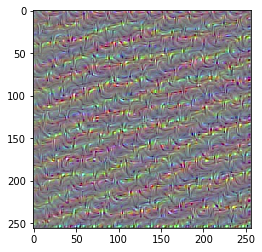

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)

#### Now, let's define a function to obtain the set of optimized images for different filters in a given layer and save in a folder.

In [1]:
from keras import backend as K
from scipy.misc import imsave
import numpy as np
import os
from skimage.io import imsave

def get_filter_visualizations(model, input_w, input_h, layer_name, no_steps, single_filter=False, single_filter_no=0):
    input_image = model.input
    
    my_layer_dict = dict([(layer.name, layer) for layer in model.layers])
    
    if single_filter == False:
        no_filters = np.array(my_layer_dict[layer_name].get_weights()[0]).shape[3]
        
        for i in range(no_filters):
            filter_index = i
            layer_o_p = my_layer_dict[layer_name].output
            loss_ = K.mean(layer_o_p[:, :, :, filter_index])
            grad = K.gradients(loss_, input_image)[0]
            grad = grad / (K.sqrt(K.mean(K.square(grad))) + 1e-05)
            iterate_model = K.function([input_image], [loss_, grad])

            input_noise = np.random.random((1, input_w, input_h, 3))*20 + 128
            step_size = 1

            for j in range(no_steps):
                L, G = iterate_model([input_noise])
                input_noise = input_noise + G*step_size 

            input_noise -= input_noise.mean()
            input_noise /= (input_noise.std() + 1e-5)
            input_noise *= 0.1

            input_noise += 0.5
            input_noise = np.clip(input_noise, 0, 1)

            input_noise *= 255
            input_noise = np.clip(input_noise, 0, 255).astype('uint8')

            input_noise = np.squeeze(input_noise)

            save_path = "Visualizations/Filter Visualizations_" + layer_name
            file_name = layer_name + "_filter_" + str(filter_index) + ".png"

            if not os.path.exists(save_path):
                os.makedirs(save_path)
            imsave('%s/%s' % (save_path, file_name),input_noise)
    else:
        no_filters = 1
        
        for i in range(no_filters):
            filter_index = single_filter_no
            layer_o_p = my_layer_dict[layer_name].output
            loss_ = K.mean(layer_o_p[:, :, :, filter_index])
            grad = K.gradients(loss_, input_image)[0]
            grad = grad / (K.sqrt(K.mean(K.square(grad))) + 1e-05)
            iterate_model = K.function([input_image], [loss_, grad])

            input_noise = np.random.random((1, input_w, input_h, 3))*20 + 128
            step_size = 1

            for j in range(no_steps):
                L, G = iterate_model([input_noise])
                input_noise = input_noise + G*step_size 

            input_noise -= input_noise.mean()
            input_noise /= (input_noise.std() + 1e-5)
            input_noise *= 0.1

            input_noise += 0.5
            input_noise = np.clip(input_noise, 0, 1)

            input_noise *= 255
            input_noise = np.clip(input_noise, 0, 255).astype('uint8')

            input_noise = np.squeeze(input_noise)

            save_path = "Visualizations/Filter Visualizations at every layer" + "_" + str(filter_index)
            file_name = layer_name + "_filter_" + str(filter_index) + ".png"

            if not os.path.exists(save_path):
                os.makedirs(save_path)
            imsave('%s/%s' % (save_path, file_name),input_noise)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras import applications

model = applications.VGG16(include_top=False, weights='imagenet')

layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
# Run below code to get the visualization of filters of individual layers

get_filter_visualizations(model, 256, 256, 'block5_conv2', 20)

In [6]:
# Run below code to get the visualization of a single filter in each of the layers.

for i, val in enumerate((list(layer_dict)[1:])):
    get_filter_visualizations(model, 256, 256, val, 20, single_filter=True, single_filter_no=13)

# _Step 4: Visualize what the CNN means by when fed by the output. Let's try to generate input image from an output label._


#### _But How?_
#### __First we'll feed noisy image to CNN. Then compute loss = output_of_noisy_image - output_of_class(which is one hot vector)__
#### _We'll compute gradient of loss w.r.t. input noisy image_
#### __We'll do gradient DESCENT as we have to minimize the loss so we will do input_image = input_image - gradient*step__

In [1]:
from keras import applications

model = applications.VGG16(include_top=True, weights='imagenet')
# include_top = False will provide us VGG16 model without last 3 fully connected layers. 
# The benefit of that is that it will enable us to feed any size of image to the model.

model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
from keras import backend as K
from keras import losses
import numpy as np
 
class_no_to_be_visualized = 340
# 340 means : zebra

input_img = model.input
layer_name = 'predictions'
predict_output = model.get_layer(layer_name).output

desired_output = np.zeros(shape=(1, 1000), dtype=np.float32)
desired_output[0][class_no_to_be_visualized] = 1

#loss_fxn = K.mean(K.square(desired_output - predict_output))

loss_fxn = losses.hinge(y_pred=predict_output, y_true=desired_output)

gradient = K.gradients(loss_fxn, input_img)[0]

gradient = gradient / (K.sqrt(K.mean(K.square(gradient))) + 1e-05)

iterate = K.function([input_img], [loss_fxn, gradient])

In [3]:
import numpy as np
import time

initial_time = time.time()

w = 224
h = 224
# w and h needs to be exact same as input shape requirements of VGG16 as we are having Fully connected layers in the model.

input_img_data = np.random.random((1, w, h, 3))*20 + 128
before = input_img_data
step_size = 1000
# as the gradient is very small, in the scale of 10^-5

steps = 10000
for i in range(steps):
    loss, grads = iterate([input_img_data])
    if (i+1) % 100 == 0:
        print("Step: {}/{}".format(i+1, steps), "Loss: ", loss, "Max G: ", np.amax(grads), "Min G: ", np.amin(grads))
        hundred_time = time.time()
        diff = hundred_time - initial_time
        req_time = int(((steps-i)*diff) / i)
        print("Remaining time: ", req_time / 60, "mins")
    input_img_data = input_img_data - grads*step_size

Step: 100/10000 Loss:  [0.99900013] Max G:  1.5677408e-05 Min G:  -1.345371e-05
Remaining time:  29.816666666666666 mins
Step: 200/10000 Loss:  [0.9990001] Max G:  4.9675364e-06 Min G:  -6.0617785e-06
Remaining time:  27.0 mins
Step: 300/10000 Loss:  [0.999] Max G:  3.1984764e-06 Min G:  -3.239078e-06
Remaining time:  26.183333333333334 mins
Step: 400/10000 Loss:  [0.999] Max G:  2.137469e-06 Min G:  -2.2223342e-06
Remaining time:  25.383333333333333 mins
Step: 500/10000 Loss:  [0.999] Max G:  1.6992299e-06 Min G:  -1.7032904e-06
Remaining time:  24.816666666666666 mins
Step: 600/10000 Loss:  [0.999] Max G:  1.4110113e-06 Min G:  -1.4678794e-06
Remaining time:  24.383333333333333 mins
Step: 700/10000 Loss:  [0.999] Max G:  1.1907972e-06 Min G:  -1.2418898e-06
Remaining time:  24.016666666666666 mins
Step: 800/10000 Loss:  [0.999] Max G:  1.0870651e-06 Min G:  -9.823225e-07
Remaining time:  23.666666666666668 mins
Step: 900/10000 Loss:  [0.999] Max G:  8.9103423e-07 Min G:  -8.6827794e-

Step: 7400/10000 Loss:  [0.999] Max G:  1.1987413e-07 Min G:  -1.2908029e-07
Remaining time:  6.683333333333334 mins
Step: 7500/10000 Loss:  [0.999] Max G:  1.2169603e-07 Min G:  -1.3180296e-07
Remaining time:  6.433333333333334 mins
Step: 7600/10000 Loss:  [0.999] Max G:  1.10853584e-07 Min G:  -1.2140326e-07
Remaining time:  6.183333333333334 mins
Step: 7700/10000 Loss:  [0.999] Max G:  1.11573684e-07 Min G:  -1.1839335e-07
Remaining time:  5.916666666666667 mins
Step: 7800/10000 Loss:  [0.999] Max G:  1.0101669e-07 Min G:  -1.143514e-07
Remaining time:  5.666666666666667 mins
Step: 7900/10000 Loss:  [0.999] Max G:  9.6417246e-08 Min G:  -1.14362095e-07
Remaining time:  5.4 mins
Step: 8000/10000 Loss:  [0.999] Max G:  9.594075e-08 Min G:  -1.15616395e-07
Remaining time:  5.15 mins
Step: 8100/10000 Loss:  [0.999] Max G:  9.8618536e-08 Min G:  -1.1381462e-07
Remaining time:  4.883333333333334 mins
Step: 8200/10000 Loss:  [0.999] Max G:  9.829869e-08 Min G:  -1.1544325e-07
Remaining tim

In [10]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# input_img_data will be having 1, 224, 224, 3 shape so we'll use its first element to obtain the np array having 224, 224, 3 shape
img = input_img_data[0]
img = deprocess_image(img)

#### _Now, let's plot the images - Original (before) and Output(Processed)_ 

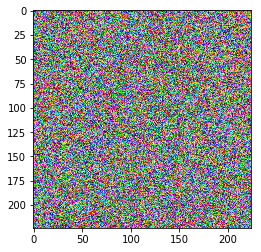

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.squeeze(before))

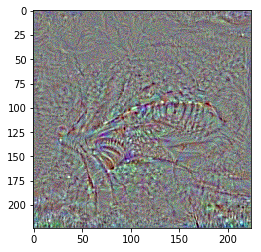

In [12]:
plt.imshow(img)

#### _Now, that we have the generated image, let's test it to get the model's prediction just to cross check what we have got._

In [13]:
X = np.expand_dims(img, 0)
output = model.predict(x=X)

print("Predicted Class no: ", np.argmax(output))

Predicted Class no:  340


### As we can see, the image that we get after optimizing the original noise is shown above. When that image has been fed to the model it has generated the same class with which we have started. But by looking at the generated image we are far away from visualizing it as a ZEBRA for class no. 340. 

### So it was an failed attempt to visualize what CNN interprete as an output value.